Number of characters detected in training image after refinement: 10


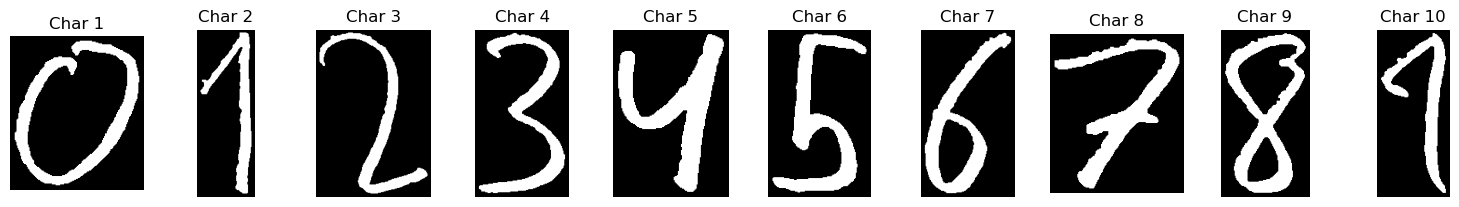

Training MLP Classifier...
MLP Classifier trained successfully.

Evaluating the classifier on validation set:
Validation Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12

Confusion Matrix:
[[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 

/Users/michaelrantisi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/michaelrantisi/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

def preprocess_image_filtered(image_path, min_width=20, min_height=20, max_width=300, max_height=300):
    # Image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image at path {image_path} could not be loaded.")
    
    # Gaussian Blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Binarize the image
    _, binary_image = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    
    # Morphological Opening to remove small noise
    opened = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Morphological Closing to connect fragmented parts
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    # Find contours
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours based on size
    filtered_contours = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if min_width <= w <= max_width and min_height <= h <= max_height:
            filtered_contours.append(cnt)
    
    # Sort contours left to right
    sorted_contours = sorted(filtered_contours, key=lambda x: cv2.boundingRect(x)[0])
    
    # Extract character images
    characters = []
    for cnt in sorted_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        # Add padding just in case 
        padding = 5
        character = closed[max(y - padding, 0):y + h + padding, max(x - padding, 0):x + w + padding]
        characters.append(character)
    
    return characters

def resize_characters(characters, size=(50, 70)):
    resized_chars = [cv2.resize(char, size, interpolation=cv2.INTER_AREA) for char in characters]
    return resized_chars

def extract_features(characters):
    features = []
    for char in characters:
        # Ensure the character image is of the expected size
        if char.shape != (70, 50):
            char = cv2.resize(char, (50, 70), interpolation=cv2.INTER_AREA)
        
        # Divide into 5x7 (10x10 pixels each) segments
        avg_brightness = []
        grid_height = 70 // 7 
        grid_width = 50 // 5  
        for i in range(0, 70, grid_height):
            for j in range(0, 50, grid_width):
                grid = char[i:i+grid_height, j:j+grid_width]
                avg_brightness.append(np.mean(grid))
        
        # Normalize brightness values
        avg_brightness = np.array(avg_brightness) / 255.0
        features.append(avg_brightness)
    
    return np.array(features)

def augment_image(image, num_augmentations=5):
    augmented_images = []
    rows, cols = image.shape
    for _ in range(num_augmentations):
        # Random rotation between -15 and 15 degrees
        angle = np.random.uniform(-15, 15)
        M_rot = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        rotated = cv2.warpAffine(image, M_rot, (cols, rows), borderMode=cv2.BORDER_REPLICATE)
        
        # Random translation
        tx = np.random.randint(-5, 5)
        ty = np.random.randint(-5, 5)
        M_trans = np.float32([[1, 0, tx], [0, 1, ty]])
        translated = cv2.warpAffine(rotated, M_trans, (cols, rows), borderMode=cv2.BORDER_REPLICATE)
        
        # Add to list
        augmented_images.append(translated)
    return augmented_images

def train_mlp_classifier(X_train, y_train, hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=200):

    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        activation=activation,
        solver=solver,
        max_iter=max_iter,
        random_state=42
    )
    mlp.fit(X_train, y_train)
    return mlp

def train_mlp(X_train, y_train, hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=200):
    classifier = train_mlp_classifier(
        X_train, 
        y_train, 
        hidden_layer_sizes=hidden_layer_sizes, 
        activation=activation, 
        solver=solver, 
        max_iter=max_iter
    )
    return classifier

def evaluate_classifier(classifier, X_val, y_val):
    y_pred = classifier.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {accuracy * 100:.2f}%")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))
    return accuracy

def recognize_image_mlp(image_path, classifier):
    # Preprocess test image
    test_chars = preprocess_image_filtered(image_path)
    if not test_chars:
        raise ValueError("No characters detected in the test image.")
    test_chars = resize_characters(test_chars)
    test_features = extract_features(test_chars)
    
    # Predict labels
    predictions = classifier.predict(test_features)
    recognized_text = ''.join(predictions)
    print("Recognized Text:", recognized_text)
    return recognized_text

def visualize_characters(characters):
    num_chars = len(characters)
    cols = min(10, num_chars)
    rows = (num_chars // cols) + 1
    plt.figure(figsize=(15, 2 * rows))
    for idx, char in enumerate(characters):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(char, cmap='gray')
        plt.title(f'Char {idx+1}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def main():
    # training and test images
    train_image_path = '/Users/michaelrantisi/Desktop/IS-Lab-4/numbers_train.jpg'  
    test_image_path = '/Users/michaelrantisi/Desktop/IS-Lab-4/numbers_test.jpg'      
    
    # Preprocess and segment training image
    train_chars = preprocess_image_filtered(train_image_path)
    print(f"Number of characters detected in training image after refinement: {len(train_chars)}")
    
    if len(train_chars) == 0:
        raise ValueError("No characters detected in the training image.")
    
    # Visualize detected training characters
    visualize_characters(train_chars)
    
    # Assign training labels
    # Replace "0123456789" with your actual labels corresponding to the characters in the training image
    train_labels = list("0123456789")  # Example for 10 digits
    
    if len(train_labels) != len(train_chars):
        raise ValueError(f"Number of labels ({len(train_labels)}) does not match number of characters ({len(train_chars)}).")
    
    # Resize and extract features from training characters
    train_chars_resized = resize_characters(train_chars)
    train_features = extract_features(train_chars_resized)
    
    # Data Augmentation: Generate additional samples
    augmented_train_chars = []
    augmented_train_labels = []
    
    for char, label in zip(train_chars_resized, train_labels):
        augmented_images = augment_image(char, num_augmentations=5)
        augmented_train_chars.extend(augmented_images)
        augmented_train_labels.extend([label] * len(augmented_images))
    
    # Combine original and augmented data
    all_train_chars_resized = train_chars_resized + augmented_train_chars
    all_train_labels = train_labels + augmented_train_labels
    
    # Extract features from augmented data
    all_train_features = extract_features(all_train_chars_resized)
    
    # Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        all_train_features, 
        all_train_labels, 
        test_size=0.2, 
        random_state=42, 
        stratify=all_train_labels
    )
    
    # Train the MLP classifier
    hidden_layer_sizes = (100,) 
    activation = 'relu'
    solver = 'adam'
    max_iter = 300
    
    print("Training MLP Classifier...")
    classifier = train_mlp(
        X_train, 
        y_train, 
        hidden_layer_sizes=hidden_layer_sizes, 
        activation=activation, 
        solver=solver, 
        max_iter=max_iter
    )
    print("MLP Classifier trained successfully.")
    
    # Validate the classifier
    print("\nEvaluating the classifier on validation set:")
    accuracy = evaluate_classifier(classifier, X_val, y_val)
    
    # Recognize characters in the test image
    print("\nRecognizing characters in the test image:")
    recognized_text = recognize_image_mlp(test_image_path, classifier)
    
    # Optional: Reduce the number of hidden neurons and retrain
    reduced_hidden_layer_sizes = (70,) 
    print("\nTraining MLP Classifier with reduced hidden neurons...")
    classifier_reduced = train_mlp(
        X_train, 
        y_train, 
        hidden_layer_sizes=reduced_hidden_layer_sizes, 
        activation=activation, 
        solver=solver, 
        max_iter=max_iter
    )
    print("Reduced MLP Classifier trained successfully.")
    
    # Validate the reduced classifier
    print("\nEvaluating the reduced classifier on validation set:")
    accuracy_reduced = evaluate_classifier(classifier_reduced, X_val, y_val)
    
    # Recognize characters with the reduced classifier
    print("\nRecognizing characters in the test image with reduced classifier:")
    recognized_text_reduced = recognize_image_mlp(test_image_path, classifier_reduced)

if __name__ == "__main__":
    main()
